# 衛星データを用いた解析事例  -サンプルコード-  
  
今回は、日本初の衛星データプラットフォームTellusのAPIを使った解析例を紹介します。  

## ■AVNIR-2データを用いた耕作が行われていない圃場の探査

In [ ]:
## データの読み込み
## google driveと接続
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.3 MB 5.3 MB/s 
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 417 kB/s 
     |████████████████████████████████| 6.3 MB 51.2 MB/s 


In [ ]:
import os
import requests
import json
import glob
import rasterio.mask
import fiona

import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import show_hist

### １．衛星データの検索・取得
Tellusの外部APIを活用した衛星データダウンロード用のスクリプトです。  
詳細は[こちら](https://www.tellusxdp.com/docs/travelers/)をご参考ください。

In [ ]:
def get_dataset_data_by_id_files(base_path, token, dataset_id, data_id):
    print(base_path, token, dataset_id, data_id)
    url = '{}/api/traveler/v1/datasets/{}/data/{}/files/'.format(
        base_path, dataset_id, data_id)
    headers = {
        'Authorization': 'Bearer ' + token,
        'content-type': 'application/json'
    }
    r = requests.get(url, headers=headers)
    assert r.status_code == 200
    return json.loads(r.content)

def get_dataset_data_by_id_files_by_id_download_url(base_path, token, dataset_id, data_id, file_id):
    url = '{}/api/traveler/v1/datasets/{}/data/{}/files/{}/download-url/'.format(
        base_path, dataset_id, data_id, file_id)
    headers = {
        'Authorization': 'Bearer ' + token,
        'content-type': 'application/json'
    }
    r = requests.post(url, headers=headers)
    assert r.status_code == 200
    return json.loads(r.content)

def download(scenes, dataset_id, token, dist='./', base_path='https://www.tellusxdp.com'):
    for scene_id in scenes:       
        files = get_dataset_data_by_id_files(
            base_path, token, dataset_id, scene_id)
        print(files)
        rawdata = files['results']
        path = os.path.join(dist, scene_id)
        if len(rawdata) > 0:
            for file in rawdata:
                file_id = file['id']
                file_name = file['name']

                file_path = os.path.join(path, file_name)

                download_url = get_dataset_data_by_id_files_by_id_download_url(
                        base_path, token, dataset_id, scene_id, file_id)['download_url']

                r = requests.get(download_url, stream=True)

                if not os.path.exists(path):
                    os.makedirs(path)

                with open(file_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=1024):
                        if chunk:

                            f.write(chunk)
                            f.flush()

In [ ]:
"""
１．データダウンロード
  ## 準備 ##
  AVNIR-2のデータはTellus外部APIから取得可能
  AVNIR-2 dataset id : ea71ef6e-9569-49fc-be16-ba98d876fb73
  
  シーン単位のIDを取得
  Tellus Travelerから検索すると簡単
  https://www.tellusxdp.com/traveler/viewer/

  Tellus APIトークンの発行
  トークンはダッシュボード＞開発環境＞APIアクセス
  以下のページの「APIを使用するためのトークンの発行」を参照
  https://www.tellusxdp.com/ja/howtouse/dev/install_development_environment.html

"""
dataset_id='ea71ef6e-9569-49fc-be16-ba98d876fb73'

scenes = [
    '202ce08d-ba4b-4ffe-8165-109fd3a8b917',
    '34d8dc6f-fdd1-4542-a038-c1235a5a97fa',
    '9d14706f-cee7-4eb4-9151-2558609c3de0',
    '208a3618-7700-421b-bf05-fd59551cc1aa',
    'e2e85b2e-a208-4a65-87fd-b92721b037a8',
    '3f4555ac-eaf3-4066-a1ba-20bb1ec1c0b3',
    '12ad308b-6ce1-40ec-9ebf-f0215c30500e'
]

#各個人のAPIトークンを入力
token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

# データDL
download(scenes, dataset_id, token)

https://www.tellusxdp.com 524e286c-d7ef-4cb2-89d4-83d7643f0709 ea71ef6e-9569-49fc-be16-ba98d876fb73 e2e85b2e-a208-4a65-87fd-b92721b037a8
{'results': [{'id': 1, 'name': 'HDR-ALAV2A148202780-OORIRFU-D069P3-20081105-000.txt', 'status': 'uploaded', 'size_bytes': 1784}, {'id': 2, 'name': 'IMG-01-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif', 'status': 'uploaded', 'size_bytes': 85203240}, {'id': 3, 'name': 'ALAV2A148202780_webcog.tif', 'status': 'uploaded', 'size_bytes': 217599353}, {'id': 4, 'name': 'IMG-03-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif', 'status': 'uploaded', 'size_bytes': 85203240}, {'id': 5, 'name': 'IMG-04-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif', 'status': 'uploaded', 'size_bytes': 85203240}, {'id': 6, 'name': 'ALAV2A148202780-OORIRFU-D069P3-20081105-000_thumb.png', 'status': 'uploaded', 'size_bytes': 344059}, {'id': 7, 'name': 'IMG-02-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif', 'status': 'uploaded', 'size_bytes': 85203240}]}


### ２．NDVI（正規化植生指数）の算出

In [ ]:
def mk_ndvi_rio(red_img, nir_img, red_gain, red_offset, nir_gain, nir_offset, out_ndvi):
  """
    NAME:
        make_ndvi_rio
    
    ARGUMENT:
        red_img   : 赤バンド画象
        nir_img   : 赤外パンド画像
        red_gain  : 赤バンドゲイン
        red_offset: 赤バンドオフセット
        nir_gain  : 赤外バンドゲイン
        nir_offset: 赤外バンドオフセット
        out_ndvi  : NDVI画像

    DISCRIPTION:
　      The original code was written by N.Furuta 

        ■DN値から輝度値への変換式
          L = a×O+b
            L：輝度（W/m2/sr/μm）
            O：校正済みデジタル値(DN値)
            a：絶対校正係数(ゲイン値)
            b：オフセット値
            ※プロダクトフォーマット説明書 AVNIR-2編、表3.3-8 アンシラリ2（ラジオメトリック校正）レコード、p3-30 参照　
        
        ■NDVI値の計算
          (近赤外バンド - 赤バンド)/(近赤外バンド + 赤バンド)
          ※本来は輝度値をさらに地上反射率へ変換したものを利用
          ※本関数では簡単のため輝度値を用いて計算（簡易NDVI）
        
    RETURN:
        out_ndvi : NDVI画像（パス）
  """
  
  red = rio.open(red_img)
  nir = rio.open(nir_img)

  red_arr = red.read().astype(float)
  nir_arr = nir.read().astype(float)

  kwargs = {
      "width" : red.width,
      "height" : red.height,
      "count" : 1,
      "crs" : red.crs,
      "transform" : red.transform,
      "dtype" : rio.float32}
      
  ## DN2輝度変換
  red_arr = red_arr * red_gain + red_offset
  nir_arr = nir_arr * nir_gain + nir_offset
  
  ## NDVI算出
  ndvi = np.where(((red_arr != 0) & (nir_arr != 0)),((nir_arr - red_arr) / (nir_arr + red_arr) ),0)

  write_ndvi = rio.open(out_ndvi,"w",driver="Gtiff",**kwargs)
  write_ndvi.write(ndvi)
  write_ndvi.close()

  return(out_ndvi)

In [ ]:
"""
２．NDVI画像の作成
  ## HDR情報は公式ドキュメントを参照
  https://www.eorc.jaxa.jp/ALOS/alos-ori/doc/AVNIR-2_ORI_format_jp.pdf

"""
# 衛星画像（AVNIR-2）を保存しているフォルダを指定
# 自身の環境に合わせて指定先は変更してください
DATA_DIR = "/content/drive/MyDrive/work/study/Sorabatake/02_data"
DIR_LIST = os.listdir(DATA_DIR)

# NDVI画像の保存先のフォルダを指定
NDVI_DIR = "/content/drive/MyDrive/work/study/Sorabatake/03_ndvi"
#print(DIR_LIST) 

#データを取得
for dir_name in DIR_LIST:

  dir_path = os.path.join(DATA_DIR, dir_name)
  #print(dir_path)

  subdir_list = os.listdir(dir_path)
  red_path = glob.glob(dir_path + "/IMG-03-*.tif")
  nir_path = glob.glob(dir_path + "/IMG-04-*.tif")
  hdr_path = glob.glob(dir_path + "/HDR-*.txt")
  hdr_path = str(hdr_path[0])
  #print(hdr_path)

  # HDR情報から、ゲイン、オフセット情報を抽出
  hdr_f = open(hdr_path,"r")
  hdr_data = hdr_f.read()
  hdr_f.close

  # gain, offset
  red_gain = float(hdr_data[1753:1761])
  red_offset = float(hdr_data[1761:1769])
  nir_gain = float(hdr_data[1769:1777])
  nir_offset = float(hdr_data[1777:1785])
  print(red_gain, red_offset, nir_gain, nir_offset)

  red_path = red_path[0]
  nir_path = nir_path[0]
  print(red_path, nir_path)
  
  #NDVI画像の作成
  base_name = os.path.basename(red_path)
  ndvi_file = "NDVI-" + base_name[7:]
  ndvi_path = os.path.join(NDVI_DIR, ndvi_file)
  
  #ndvi_img = mk_ndvi_rio(red_path, nir_path, red_gain, red_offset, nir_gain, nir_offset, ndvi_path)
  #print(ndvi_img)

0.502 0.0 0.835 0.0
/content/drive/MyDrive/work/study/Sorabatake/02_data/12ad308b-6ce1-40ec-9ebf-f0215c30500e/IMG-03-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif /content/drive/MyDrive/work/study/Sorabatake/02_data/12ad308b-6ce1-40ec-9ebf-f0215c30500e/IMG-04-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif
0.502 0.0 0.835 0.0
/content/drive/MyDrive/work/study/Sorabatake/02_data/9d14706f-cee7-4eb4-9151-2558609c3de0/IMG-03-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif /content/drive/MyDrive/work/study/Sorabatake/02_data/9d14706f-cee7-4eb4-9151-2558609c3de0/IMG-04-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif
0.502 0.0 0.557 0.0
/content/drive/MyDrive/work/study/Sorabatake/02_data/202ce08d-ba4b-4ffe-8165-109fd3a8b917/IMG-03-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif /content/drive/MyDrive/work/study/Sorabatake/02_data/202ce08d-ba4b-4ffe-8165-109fd3a8b917/IMG-04-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif
0.502 0.0 0.835 0.0
/content/drive/MyDrive/work/study/Sorabatake/02_da

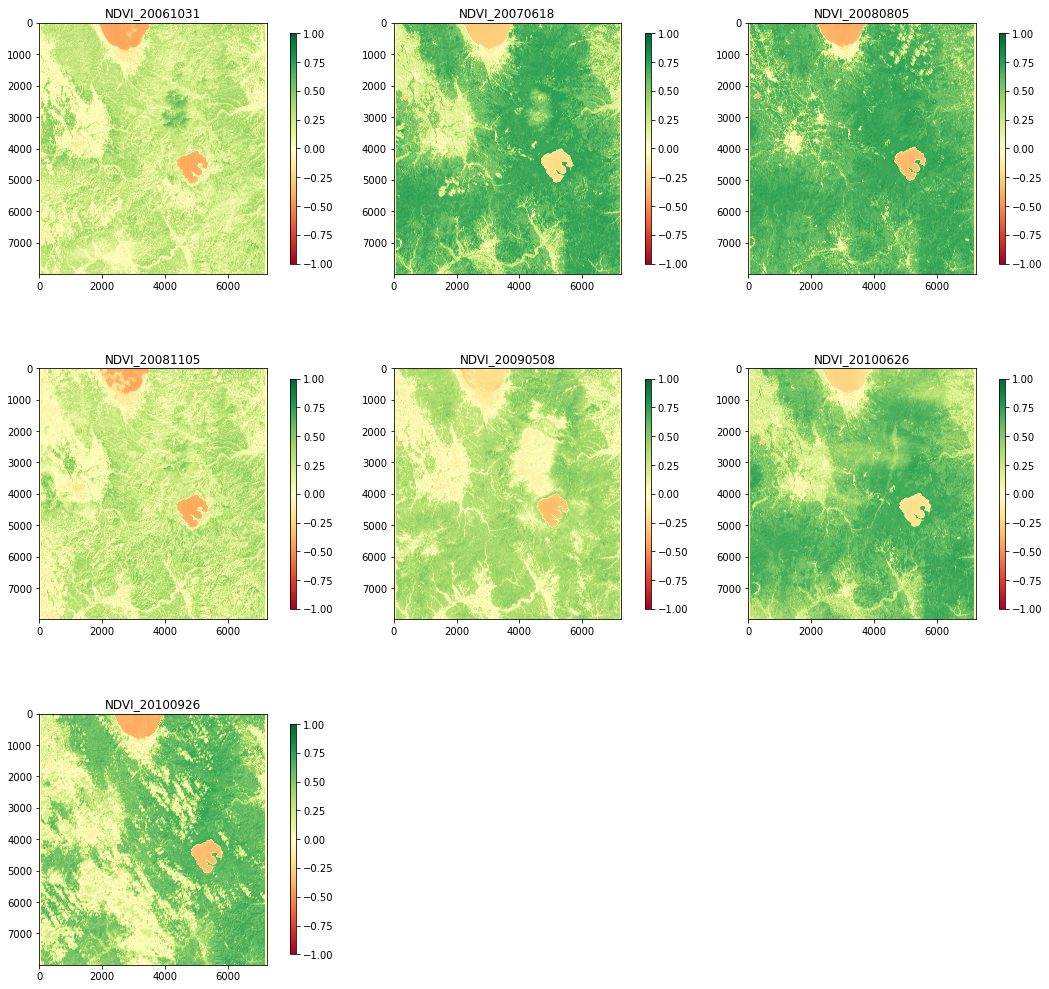

In [ ]:
#NDVI画像の表示（無茶苦茶ごり押しですみません、、、）
NDVI_20061031 = rio.open(NDVI_DIR + "/NDVI-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif")
NDVI_20070618 = rio.open(NDVI_DIR + "/NDVI-ALAV2A074392780-OORIRFU-D069P3-20070618-002.tif")
NDVI_20080805 = rio.open(NDVI_DIR + "/NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif")
NDVI_20081105 = rio.open(NDVI_DIR + "/NDVI-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif")
NDVI_20090508 = rio.open(NDVI_DIR + "/NDVI-ALAV2A175042780-OORIRFU-D069P3-20090508-003.tif")
NDVI_20100626 = rio.open(NDVI_DIR + "/NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif")
NDVI_20100926 = rio.open(NDVI_DIR + "/NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif")

NDVI_20061031 = NDVI_20061031.read(1)
NDVI_20070618 = NDVI_20070618.read(1)
NDVI_20080805 = NDVI_20080805.read(1)
NDVI_20081105 = NDVI_20081105.read(1)
NDVI_20090508 = NDVI_20090508.read(1)
NDVI_20100626 = NDVI_20100626.read(1)
NDVI_20100926 = NDVI_20100926.read(1)

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)

img1 = ax1.imshow(NDVI_20061031, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title("NDVI_20061031")
cbar1 = fig.colorbar(img1,ax=ax1, aspect=40,pad=0.08,shrink=0.8)
img2 = ax2.imshow(NDVI_20070618, cmap='RdYlGn', vmin=-1, vmax=1)
ax2.set_title("NDVI_20070618")
cbar2 = fig.colorbar(img2,ax=ax2, aspect=40,pad=0.08,shrink=0.8)
img3 = ax3.imshow(NDVI_20080805, cmap='RdYlGn', vmin=-1, vmax=1)
ax3.set_title("NDVI_20080805")
cbar3 = fig.colorbar(img3,ax=ax3, aspect=40,pad=0.08,shrink=0.8)
img4 = ax4.imshow(NDVI_20081105, cmap='RdYlGn', vmin=-1, vmax=1)
ax4.set_title("NDVI_20081105")
cbar4 = fig.colorbar(img4,ax=ax4, aspect=40,pad=0.08,shrink=0.8)
img5 = ax5.imshow(NDVI_20090508, cmap='RdYlGn', vmin=-1, vmax=1)
ax5.set_title("NDVI_20090508")
cbar5 = fig.colorbar(img5,ax=ax5, aspect=40,pad=0.08,shrink=0.8)
img6 = ax6.imshow(NDVI_20100626, cmap='RdYlGn', vmin=-1, vmax=1)
ax6.set_title("NDVI_20100626")
cbar6 = fig.colorbar(img6,ax=ax6, aspect=40,pad=0.08,shrink=0.8)
img7 = ax7.imshow(NDVI_20100926, cmap='RdYlGn', vmin=-1, vmax=1)
ax7.set_title("NDVI_20100926")
cbar7 = fig.colorbar(img7,ax=ax7, aspect=40,pad=0.08,shrink=0.8)

plt.show(fig)

### ３．NDVI画像の切り出し  
今回はサンプルとして青森県藤崎町を対象に、NDVI解析を行っていきます。  
ここでは初めに上記で算出したNDVI画像を藤崎町の区画に沿って切り出しを行います。
    
※藤崎町の区画ポリゴンは国土地理院が公開している国土数値情報のうち、行政区域データ（[LINK](https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v2_3.html)）を利用しています。

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:640: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<function matplotlib.pyplot.show>

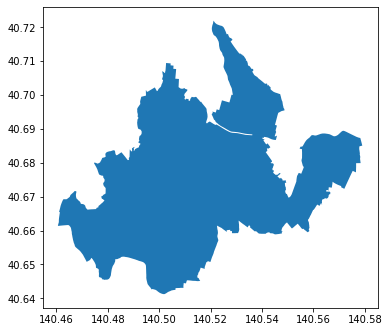

In [ ]:
# 青森県全域の行政区域データの中から藤崎町だけのDVI値を切り抜く
# 藤崎町のポリゴンを抽出

# 行政区域データの保存先のフォルダを指定
# ※自身の環境に合わせて指定先は変更してください
AOMORI_PATH = "/content/drive/MyDrive/work/study/Sorabatake/04_polygon/Aomori_N03-20210101_02_GML/"
# そのうちshape形式のデータを指定
AOMORI_SHP = "N03-21_02_210101.shp"
df_aomori = gpd.read_file(os.path.join(AOMORI_PATH, AOMORI_SHP), encoding="shift-jis")

Fujisaki_machi = df_aomori[df_aomori["N03_004"].isin(["藤崎町"])]
Fujisaki_machi = Fujisaki_machi.drop(columns=["N03_002","N03_003"])

#投影変換
reprojest_Fujisaki_machi = Fujisaki_machi.to_crs({"init":"epsg:32654"})
reproject_out = os.path.join(AOMORI_PATH, "epsg_32654-"+ AOMORI_SHP)
#出力
reprojest_Fujisaki_machi.to_file(driver="ESRI Shapefile",filename=reproject_out)

#GeoDataFrameを描画
f,ax = plt.subplots(1, figsize=(6,6))
ax = Fujisaki_machi.plot(axes=ax)
plt.show

In [ ]:
## NDVI画像を藤崎町のポリゴンでマスク処理 -> マスク済画像として保存

# マスク処理済み画像の保存先のフォルダを指定
# ※自身の環境に合わせて指定先は変更してください
MASK_DIR = "/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked"
ndvi_list = os.listdir(NDVI_DIR)
ndvi_list = [f for f in ndvi_list if os.path.isfile(os.path.join(NDVI_DIR, f))]

for ndvi_file_name in ndvi_list:

  print("処理開始：" + ndvi_file_name)

  with fiona.open(reproject_out, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  ndvi_data = os.path.join(NDVI_DIR, ndvi_file_name)
  print(ndvi_data)
  print(masks)
  with rasterio.open(ndvi_data) as src:
    out_image, out_transform = rasterio.mask.mask(src, masks, nodata=np.nan, crop=True)
    out_meta = src.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
  
  with rasterio.open(MASK_DIR + "/Masked-" + str(ndvi_file_name), "w", **out_meta) as dst:
    dst.write(out_image)

処理開始：NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif
[{'type': 'Polygon', 'coordinates': [[(459965.8985635518, 4507610.411543055), (459986.32003481884, 4507554.486592676), (460005.9341799202, 4507559.262093436), (460025.7062978931, 4507561.233617488), (460027.8951671965, 4507553.94138911), (460052.0891456174, 4507524.276922859), (460039.85987210984, 4507515.875157662), (460044.69507763325, 4507503.219293943), (460051.9823158016, 4507503.621104119), (460061.3430293818, 4507475.485725569), (460099.71754548955, 4507427.280807402), (460124.1940765265, 4507437.006885386), (460144.9979841041, 4507412.208391124), (460145.43235328386, 4507411.690925658), (460179.2544797645, 4507371.373441269), (460115.08511691954, 4507318.450542459), (460123.19335601677, 4507304.040867277), (460168.568220619, 4507233.954231328), (460179.1839766846, 4507218.449183218), (460230.9833355291, 4507142.87117

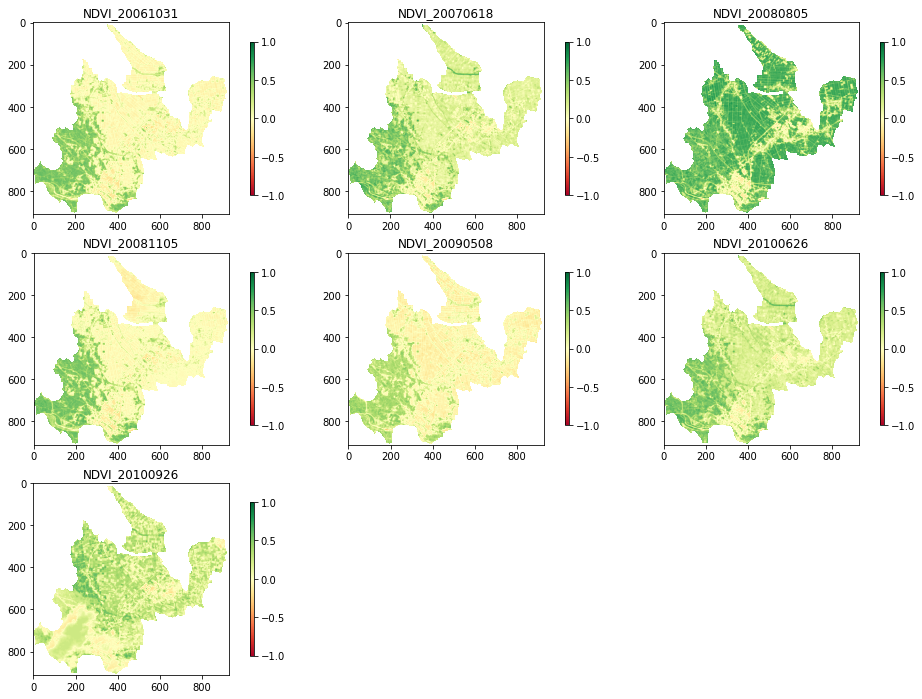

In [ ]:
#藤崎町で切り出したNDVI画像の表示（無茶苦茶ごり押しですみません、、、）
masked_NDVI_20061031 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif")
masked_NDVI_20070618 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A074392780-OORIRFU-D069P3-20070618-002.tif")
masked_NDVI_20080805 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif")
masked_NDVI_20081105 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif")
masked_NDVI_20090508 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A175042780-OORIRFU-D069P3-20090508-003.tif")
masked_NDVI_20100626 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif")
masked_NDVI_20100926 = rio.open(MASK_DIR + "/Masked-NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif")

masked_NDVI_20061031 = masked_NDVI_20061031.read(1)
masked_NDVI_20070618 = masked_NDVI_20070618.read(1)
masked_NDVI_20080805 = masked_NDVI_20080805.read(1)
masked_NDVI_20081105 = masked_NDVI_20081105.read(1)
masked_NDVI_20090508 = masked_NDVI_20090508.read(1)
masked_NDVI_20100626 = masked_NDVI_20100626.read(1)
masked_NDVI_20100926 = masked_NDVI_20100926.read(1)

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)

img1 = ax1.imshow(masked_NDVI_20061031, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title("NDVI_20061031")
cbar1 = fig.colorbar(img1,ax=ax1, aspect=40,pad=0.08,shrink=0.8)
img2 = ax2.imshow(masked_NDVI_20070618, cmap='RdYlGn', vmin=-1, vmax=1)
ax2.set_title("NDVI_20070618")
cbar2 = fig.colorbar(img2,ax=ax2, aspect=40,pad=0.08,shrink=0.8)
img3 = ax3.imshow(masked_NDVI_20080805, cmap='RdYlGn', vmin=-1, vmax=1)
ax3.set_title("NDVI_20080805")
cbar3 = fig.colorbar(img3,ax=ax3, aspect=40,pad=0.08,shrink=0.8)
img4 = ax4.imshow(masked_NDVI_20081105, cmap='RdYlGn', vmin=-1, vmax=1)
ax4.set_title("NDVI_20081105")
cbar4 = fig.colorbar(img4,ax=ax4, aspect=40,pad=0.08,shrink=0.8)
img5 = ax5.imshow(masked_NDVI_20090508, cmap='RdYlGn', vmin=-1, vmax=1)
ax5.set_title("NDVI_20090508")
cbar5 = fig.colorbar(img5,ax=ax5, aspect=40,pad=0.08,shrink=0.8)
img6 = ax6.imshow(masked_NDVI_20100626, cmap='RdYlGn', vmin=-1, vmax=1)
ax6.set_title("NDVI_20100626")
cbar6 = fig.colorbar(img6,ax=ax6, aspect=40,pad=0.08,shrink=0.8)
img7 = ax7.imshow(masked_NDVI_20100926, cmap='RdYlGn', vmin=-1, vmax=1)
ax7.set_title("NDVI_20100926")
cbar7 = fig.colorbar(img7,ax=ax7, aspect=40,pad=0.08,shrink=0.8)

plt.show(fig)

### ４．耕作が行われていない可能性のある圃場を抽出
耕作が行われていない可能性のある圃場を抽出してみます。

これらの判定条件として、ここでは稲の作付けがされていない圃場、つまり周囲と比較してNDVI値の季節変動が少ない圃場や夏場のNDVI値が小さい圃場を判定のための簡易的な条件とします。
  
しかし、闇雲にシーン全体から上記の条件を当てはめてしまっても、圃場以外のエリアも大量に抽出されてしまうことが考えられます。そのため、まず初めにどこが圃場なのかを判定する必要があります。その上で、全ての時期のNDVIデータにおいてNDVIの変化が少ない圃場を抽出することとします。  
  
圃場データとして、ここでは農林水産省が公開している[筆ポリゴンデータ](https://www.maff.go.jp/j/tokei/porigon/)を利用します※。これは圃場の一つ一つが単一のポリゴンとして格納されており、これを用いて、それぞれの圃場ごとのデータを抽出することが可能となります。

※なお、この筆ポリゴンが公開されているのは2020年以降のデータであるため、実際は衛星データの撮像日である2006年～2010年と一致しませんので、あくまで参考としての利用になります。

#### ４.１　筆ポリゴンの読み込み  
はじめに筆ポリゴンデータをgeopandasのデータフレームとして読み込み、衛星画像と重畳するために投影変換を行います。


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<function matplotlib.pyplot.show>

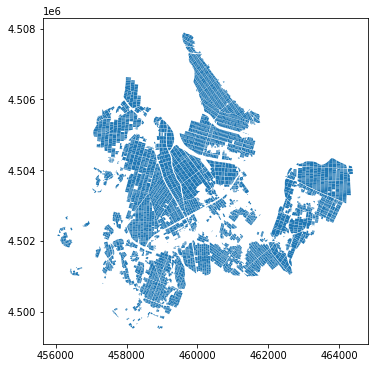

In [ ]:
## 筆ポリゴンの読み込み
## 藤崎町の筆ポリゴンを抽出

# 筆ポリゴンの保存先のフォルダを指定
# ※自身の環境に合わせて指定先は変更してください
POLYGON_PATH = "/content/drive/MyDrive/work/study/Sorabatake/06_fude_polygon/02青森県（2021公開）/02361藤崎町（2021公開）"
POLYGON_SHP = "02361藤崎町（2021公開）__aa.shp"
df_fude_polygon = gpd.read_file(os.path.join(POLYGON_PATH, POLYGON_SHP), encoding="shift-jis")

#データの確認
df_fude_polygon

Fujisaki_PaddyField = df_fude_polygon[df_fude_polygon["耕地の種類"].isin(["田"])]
Fujisaki_PaddyField = Fujisaki_PaddyField.drop(columns=["公開年度","調製年度"])

#投影変換
reprojest_Fujisaki_PaddyField = Fujisaki_PaddyField.to_crs({"init":"epsg:32654"})
reproject_PaddyFiled_out = os.path.join(POLYGON_PATH, "epsg_32654-"+ POLYGON_SHP)

#出力
reprojest_Fujisaki_PaddyField.to_file(driver="ESRI Shapefile",filename=reproject_PaddyFiled_out, encoding="shift-jis")

#抽出した藤崎町の筆ポリゴンを描画
f,ax = plt.subplots(1, figsize=(6,6))
ax = reprojest_Fujisaki_PaddyField.plot(ax=ax)
plt.show

#### ４.２ 筆ポリゴンデータに沿ってNDVI値を抽出

In [ ]:
## ポリゴンごとにgeometryを抽出し、NDVIをマスク
## 各ポリゴン内のNDVI値の平均を算出し、筆ポリゴンに新しいカラムとして追加

## 繰り返しですが、念のため
# ※自身の環境に合わせて指定先は変更してください
MASK_DIR = "/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked"
ndvi_list = os.listdir(MASK_DIR)
ndvi_list = [f for f in ndvi_list if os.path.isfile(os.path.join(MASK_DIR, f))]
print(ndvi_list)

## NDVI画像の読み込み
for ndvi_img in ndvi_list:
  ndvi_path = os.path.join(MASK_DIR, ndvi_img) 
  ndvi_title = ndvi_img[-16:-8]
  print(ndvi_path, ndvi_title)

  #ポリゴン毎のndvi値の平均を格納
  #画像毎にリスト初期化
  ndvi_mean = []

  print(str(ndvi_path) + " : 処理開始")

  with rasterio.open(ndvi_path) as ndvi_src:

    ## 筆ポリゴンの読み込み
    for index, item in reprojest_Fujisaki_PaddyField.iterrows():
      masks = item.geometry

      # 各筆ポリゴンに沿ってマスク処理 
      out_ndvi_img, out_transform = rasterio.mask.mask(ndvi_src, [masks], nodata=np.nan, crop=False)
      # マスク内のNDVI値の平均を算出 -> リストへ
      ndvi_mean.append(np.nanmean(out_ndvi_img))
      #print(np.nanmean(out_ndvi_img))
      #print("------------------")
    
    # NDVI平均値のリストをdfに結合
    reprojest_Fujisaki_PaddyField[ndvi_title] = ndvi_mean

  print(str(ndvi_path) + "処理終了")

print("---結果の確認---")
reprojest_Fujisaki_PaddyField

['Masked-NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif', 'Masked-NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif', 'Masked-NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif', 'Masked-NDVI-ALAV2A074392780-OORIRFU-D069P3-20070618-002.tif', 'Masked-NDVI-ALAV2A175042780-OORIRFU-D069P3-20090508-003.tif', 'Masked-NDVI-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif', 'Masked-NDVI-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif']
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif 20100926
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif : 処理開始


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif処理終了
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif 20080805
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif : 処理開始
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif処理終了
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif 20100626
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif : 処理開始
/content/drive/MyDrive/work/study/Sorabatake/03_ndvi/02_fujisaki_masked/Masked-NDVI-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif処理終了
/content/drive/MyDrive/work/stud

,id,耕地の種類,geometry,20100926,20080805,20100626,20070618,20090508,20061031,20081105
125,02100071735-026994,田,"POLYGON ((458933.329 4499511.147, 458896.212 4...",0.257053,0.277264,0.233712,0.181142,0.041047,0.293905,0.324842
132,02100071757-027726,田,"POLYGON ((458148.082 4499545.896, 458194.315 4...",0.059464,0.665967,0.194355,0.161223,-0.022535,0.069141,0.039732
133,02100071759-026939,田,"POLYGON ((458929.835 4499551.755, 458944.320 4...",0.187069,0.205660,0.210229,0.148465,-0.006691,0.276551,0.374468
136,02100071772-027021,田,"POLYGON ((458922.245 4499594.091, 458907.497 4...",0.348576,0.293981,0.272924,0.224112,-0.010112,0.302317,0.315776
143,02100071785-027782,田,"POLYGON ((458157.918 4499603.989, 458145.858 4...",0.082023,0.554164,0.289913,0.213802,0.247301,0.295136,0.298918
...,...,...,...,...,...,...,...,...,...,...
11649,02100079974-026130,田,"POLYGON ((459751.203 4507747.438, 459798.870 4...",0.266519,0.688402,0.216317,0.172577,-0.050220,-0.009759,0.000725
11650,02100079994-026329,田,"POLYGON ((459577.967 4507737.286, 459575.267 4...",-0.007217,0.678766,0.293742,0.315434,-0.078227,-0.022062,-0.014352
11651,02100079998-026172,田,"POLYGON ((459726.141 4507763.853, 459771.639 4...",0.109043,0.682992,0.146051,0.151102,-0.038773,-0.017701,-0.004476
11652,02100080021-026221,田,"POLYGON ((459650.850 4507812.929, 459679.367 4...",0.078713,0.715719,0.160857,0.087659,-0.085113,-0.027845,-0.013198


In [ ]:
## カラムの順番を入れ替える
## NDVI値の時系列をソート（グラフ呼び出しを簡単にするため）
recolums = ["id","耕地の種類","geometry", "20061031", "20070618", 
           "20080805", "20081105", "20090508", "20100626", "20100926"]
reprojest_Fujisaki_PaddyField = reprojest_Fujisaki_PaddyField.reindex(columns=recolums)
## dfを別名保存
reprojest_Fujisaki_PaddyField.to_file(driver='ESRI Shapefile', 
                                      filename = POLYGON_PATH + "/ndvi_clip.shp", 
                                      encoding="shift-jis")

#### ４.３ NDVI値の変動をグラフ化
ポリゴンごとに抽出したNDVIの値を時系列に沿ってグラフ化してみます。  

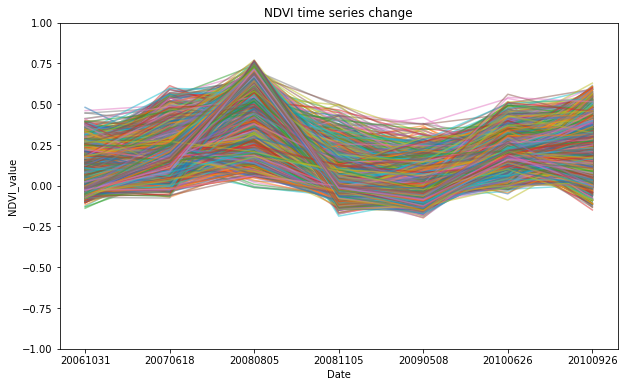

In [ ]:
## 追加したデータフレームからNDVI値を取得し、グラフ表示
# データの読み込み
# ※自身の環境に合わせて指定先は変更してください
ndvi_clip_path = "/content/drive/MyDrive/work/study/Sorabatake/06_fude_polygon/02青森県（2021公開）/02361藤崎町（2021公開）/ndvi_clip.shp"
ndvi_clip_df =  gpd.read_file(ndvi_clip_path, encoding="shift-jis")

ndvi_clip_df_t = ndvi_clip_df.drop(columns=["耕地の種類",	"geometry"])
ndvi_clip_df_t = ndvi_clip_df_t.T

list_tmp = ndvi_clip_df_t.loc["id"]
ndvi_clip_df_t = ndvi_clip_df_t.drop(index=["id"])
ndvi_clip_df_t.columns = list_tmp

ndvi_clip_df_t.plot.line( 
                         figsize = (10, 6),
                         title = "NDVI time series change",
                         ylim = ([-1.0, 1.0]),
                         xlabel = "Date",
                         ylabel = "NDVI_value",
                         alpha=0.5,
                         legend = False)

見てわかる通り、このグラフだけではデータ量（対象ポリゴン数：6538コ）が多すぎて細かいNDVIの変動が良くわかりません。 
もう少しデータ数を絞って、傾向を見てみます。

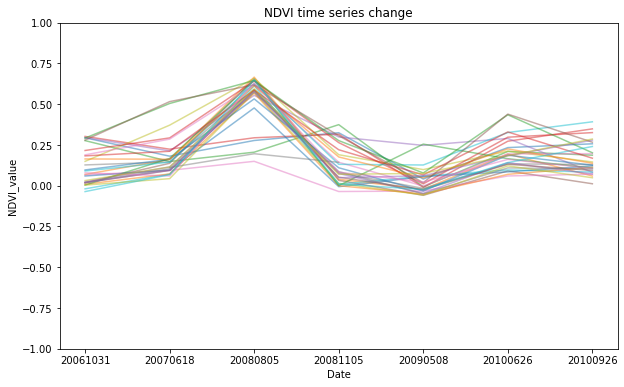

In [ ]:
# もう少しデータ数を減らしてみます
plot_item = []

# rangeの数字を変えることで表示データ数を変更可
for i in range(30):
  plot_item.append(i)

ndvi_clip_df_t.plot.line(y = plot_item, 
                         figsize = (10, 6),
                         title = "NDVI time series change",
                         ylim = ([-1.0, 1.0]),
                         xlabel = "Date",
                         ylabel = "NDVI_value",
                         alpha=0.5,
                         legend = False)

#### ４.４ 耕作がされていないポリゴンの絞り込み
耕作がされていない可能性のあるポリゴン（圃場）を絞ってみます。これらの圃場の特徴として、夏場でもNDVIの値が低いと仮定し、夏場である”20080805”のデータでNDVI値が0.0以下のポリゴンを抽出してみます。

In [ ]:
## 耕作されていない可能性のあるデータを探す
## 耕作がされていない、つまり作付けが行われていないため夏場でもNDVIの値が低いと仮定
#ndvi_clip_df=ndvi_clip_df.drop(columns=["耕地の種類",	"geometry"])
ndvi_low_id = ndvi_clip_df[ndvi_clip_df["20080805"]<= 0.0]
ndvi_low_id

,id,20061031,20070618,20080805,20081105,20090508,20100626,20100926
4589,02100076307-022264,-0.088123,0.101462,-0.008381,-0.063413,0.056215,0.083797,0.126277
5162,02100076908-025808,-0.034527,0.143029,-0.011851,-0.045723,0.184269,0.136347,0.029902
5167,02100076916-025836,-0.023233,0.213505,-0.005045,-0.052703,0.256040,0.140877,0.010905


このように夏場であってもNDVIの値が低い圃場がいくつか抽出されました。  
最後に抽出された圃場をQGISを使って確認してみます。  
  

#####４.４.１ 圃場ID【02100076307-022264, 02100076908-025808】

夏場のNDVI値が低かった圃場【02100076307-022264】と【 02100076908-025808】について、どのような状態になっているのかNDVI画像やRGB画像を見て確認してみます。  

これらの圃場は隣り合う圃場であり、藤崎町の北部に位置しています。
<figure>
  <img src ="https://drive.google.com/uc?export=view&id=1NNiW-6CLIPmrXDjy0LhDeBs3_gB3fzAU" width = "512" title = "圃場の位置関係">
  <figcaption>図4.4.1-1 圃場の位置関係(背景画像は20061031のデータ)</figcaption>
</figure>  
  
では、実際に圃場のNDVI値とRGB画像の変化を確認してみます。  

<figure>
  <img src ="https://drive.google.com/uc?export=view&id=1hn_jBtd2fX5U_tdy1QoTHnUIOe6m_Ihr" width = "1024" title = "NDVIとRGB">
  <figcaption>図4.4.1-2 圃場におけるNDVIとRGB画像の一覧)</figcaption>
</figure>  

NDVIの他、RGB画像も合わせて比較することで、実際に対象の圃場の周辺が複数の時期において裸地のような色味を示していることが確認できました。  

実際にはこの場所が実際に耕作されていないのか、それ以外の理由でこのように見えているのかが定かではありませんが、少なくとも2006年から2010年までの間においてはNDVIが低い、つまり植生が比較的少ない状態であったことがデータから示唆されます。  

このように衛星画像、特に赤外情報を含めた複数のバンドをうまく組み合わせ、時系列に解析することで地上の様子をモニタリングし、場合によっては見たい対象物（今回の場合は耕作されていない可能性のある土地）を抽出することも可能となります。  




#####４.４.２ 圃場ID【02100076916-025836】

### 付録 
  
衛星画像をカラー化する方法についてまとめます。  
手法としてはNDVI画像作成と同様に、rasterioを利用し、RGBの各バンドに適切な衛星画像を配置するものになります。  

In [ ]:
##RGB画像の作成
# 衛星画像（AVNIR-2）を保存しているフォルダと作成するRGB画像の保存先を指定
# ※自身の環境に合わせて指定先は変更してください
DATA_DIR = "/content/drive/MyDrive/work/study/Sorabatake/02_data"
RGB_DIR = "/content/drive/MyDrive/work/study/Sorabatake/05_rgb"
DIR_LIST = os.listdir(DATA_DIR)

#データを取得
for dir_name in DIR_LIST:
  dir_path = os.path.join(DATA_DIR, dir_name)
  print(dir_path)

  subdir_list = os.listdir(dir_path)
  blue_path = glob.glob(dir_path + "/IMG-01-*.tif")
  green_path = glob.glob(dir_path + "/IMG-02-*.tif")
  red_path = glob.glob(dir_path + "/IMG-03-*.tif")

  print(blue_path[0])
  b1 = rio.open(blue_path[0])
  b2 = rio.open(green_path[0])
  b3 = rio.open(red_path[0])

  base_name = os.path.basename(blue_path[0])
  rgb_file = "RGB-" + base_name[7:]
  rgb_path = os.path.join(RGB_DIR, rgb_file)
  print(rgb_path)

  # 書き込み用のデータを用意
  # パラメータは入力データ（b1：青バンド）と同様のものを指定
  with rio.open(rgb_path, 'w', driver='Gtiff', 
                width=b1.width, height=b1.height, 
                count=3, 
                transform=b1.transform,
                crs=b1.crs,
                dtype=b1.dtypes[0]) as RGB_color:
    RGB_color.write(b1.read(1),3) 
    RGB_color.write(b2.read(1),2) 
    RGB_color.write(b3.read(1),1) 
    RGB_color.close()

/content/drive/MyDrive/work/study/Sorabatake/02_data/12ad308b-6ce1-40ec-9ebf-f0215c30500e
/content/drive/MyDrive/work/study/Sorabatake/02_data/12ad308b-6ce1-40ec-9ebf-f0215c30500e/IMG-01-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif
/content/drive/MyDrive/work/study/Sorabatake/05_rgb/RGB-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif
/content/drive/MyDrive/work/study/Sorabatake/02_data/9d14706f-cee7-4eb4-9151-2558609c3de0
/content/drive/MyDrive/work/study/Sorabatake/02_data/9d14706f-cee7-4eb4-9151-2558609c3de0/IMG-01-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif
/content/drive/MyDrive/work/study/Sorabatake/05_rgb/RGB-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif
/content/drive/MyDrive/work/study/Sorabatake/02_data/202ce08d-ba4b-4ffe-8165-109fd3a8b917
/content/drive/MyDrive/work/study/Sorabatake/02_data/202ce08d-ba4b-4ffe-8165-109fd3a8b917/IMG-01-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif
/content/drive/MyDrive/work/study/Sorabatake/05_rgb/RGB-ALAV2A040842780-OORIRFU-D069P3-

作成したRGB画像を確認してみます。

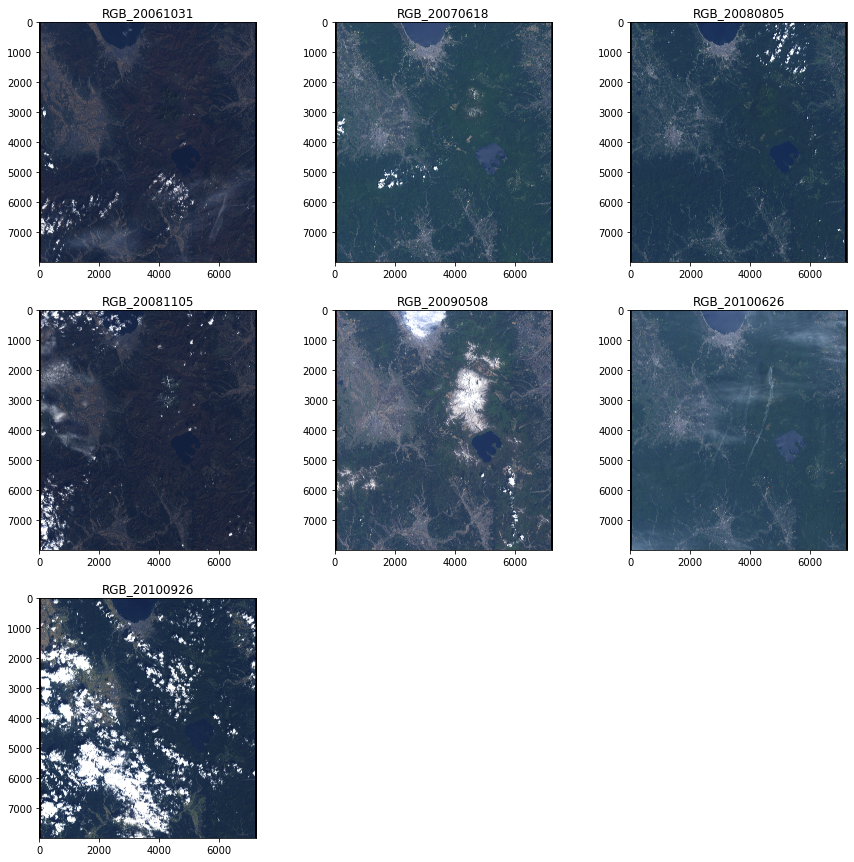

In [ ]:
#RGB画像の表示（無茶苦茶ごり押しですみません、、、）
RGB_20061031 = rio.open(RGB_DIR + "/RGB-ALAV2A040842780-OORIRFU-D069P3-20061031-001.tif")
RGB_20070618 = rio.open(RGB_DIR + "/RGB-ALAV2A074392780-OORIRFU-D069P3-20070618-002.tif")
RGB_20080805 = rio.open(RGB_DIR + "/RGB-ALAV2A134782780-OORIRFU-D069P3-20080805-003.tif")
RGB_20081105 = rio.open(RGB_DIR + "/RGB-ALAV2A148202780-OORIRFU-D069P3-20081105-000.tif")
RGB_20090508 = rio.open(RGB_DIR + "/RGB-ALAV2A175042780-OORIRFU-D069P3-20090508-003.tif")
RGB_20100626 = rio.open(RGB_DIR + "/RGB-ALAV2A235432780-OORIRFU-D069P3-20100626-002.tif")
RGB_20100926 = rio.open(RGB_DIR + "/RGB-ALAV2A248852780-OORIRFU-D069P3-20100926-001.tif")

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(331)
ax1.set_title("RGB_20061031")
ax2 = fig.add_subplot(332)
ax2.set_title("RGB_20070618")
ax3 = fig.add_subplot(333)
ax3.set_title("RGB_20080805")
ax4 = fig.add_subplot(334)
ax4.set_title("RGB_20081105")
ax5 = fig.add_subplot(335)
ax5.set_title("RGB_20090508")
ax6 = fig.add_subplot(336)
ax6.set_title("RGB_20100626")
ax7 = fig.add_subplot(337)
ax7.set_title("RGB_20100926")

show(RGB_20061031.read([1,2,3]), ax=ax1)
show(RGB_20070618.read([1,2,3]), ax=ax2)
show(RGB_20080805.read([1,2,3]), ax=ax3)
show(RGB_20081105.read([1,2,3]), ax=ax4)
show(RGB_20090508.read([1,2,3]), ax=ax5)
show(RGB_20100626.read([1,2,3]), ax=ax6)
show(RGB_20100926.read([1,2,3]), ax=ax7)

